# Fit Halo Mass from a Shear Catalog

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster.

## Setup

First, we import some standard packages.

In [1]:
# For NumCosmo
import os
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm


os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [2]:
import sys
sys.path.append('./support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM

from numpy import random

Next, we import `clmm`'s core modules.

In [3]:
import clmm
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling

Make sure we know which version we're using

In [4]:
clmm.__version__

'0.3.0'

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.
We also provide support modules for processing other specific data sets for use with `clmm`.
Any existing support module can be used as a template for creating a new support module for another data set.
If you do make such a support module, please do consider making a pull request so we can add it for others to use.

In [5]:
sys.path.append('./support')
import mock_data as mock
from sampler import samplers

## Making mock data

In [6]:
np.random.seed(12)

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [7]:
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

We now set some parameters for a mock galaxy cluster.

In [8]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
src_z = 0.8
concentration = 4
ngals = 10000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate a new galaxy catalog.

In [9]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration,
                                          cosmo, ngals, Delta, src_z)

This galaxy catalog is then converted to a `clmm.GalaxyCluster` object.

In [10]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)

A `clmm.GalaxyCluster` object can be pickled and saved for later use.

In [11]:
gc_object.save('mock_GC.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [12]:
cl = clmm.GalaxyCluster.load('mock_GC.pkl')
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec,
      "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


We can visualize the distribution of galaxies on the sky.

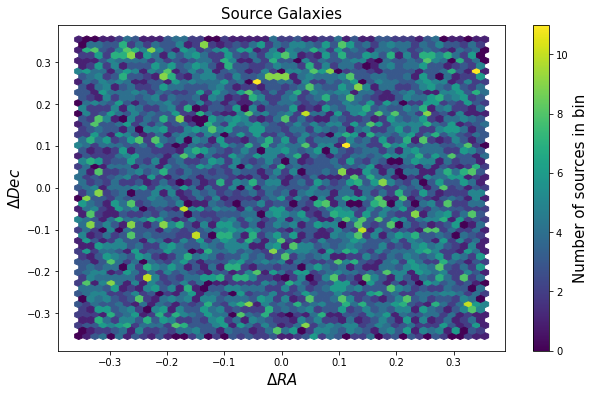

In [13]:
fsize = 15

fig = plt.figure(figsize=(10, 6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

`clmm` separates cosmology-dependent and cosmology-independent functionality.

## Deriving observables

We first demonstrate a few of the procedures one can perform on data without assuming a cosmology.

### Computing shear

`clmm.polaraveraging.compute_shear` calculates the tangential and cross shears for each source galaxy in the cluster.

In [14]:
theta, g_t, g_x = pa.compute_shear(cl, geometry="flat")

We can visualize the shear field at each galaxy location.

Text(0.5, 0, 'angular distance [rad]')

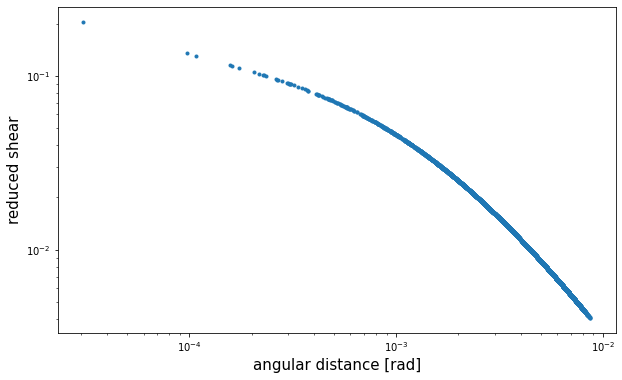

In [15]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [rad]", fontsize=fsize)

### Radially binning the data

Here we compare the reconstructed mass under two different bin definitions.

In [16]:
bin_edges1 = pa.make_bins(0.01, 3.7, 50)
bin_edges2 = pa.make_bins(0.01, 3.7, 10)

`clmm.polaraveraging.make_shear_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [17]:
res1 = pa.make_shear_profile(
    cl, "radians", "Mpc", bins=bin_edges1, cosmo=cosmo, include_empty_bins=False)
res2 = pa.make_shear_profile(
    cl, "radians", "Mpc", bins=bin_edges2, cosmo=cosmo, include_empty_bins=False)

Note that we set `include_empty_bins=False` explicitly here even though it is the default behavior. Setting the argument to `True` would also return empty bins (that is, bins with *at most one* data point in them), which would have to be excluded manually when fitting, though it might be useful e.g., when combining datasets. To clarify the behavior, consider the following comparison:

In [18]:
res_with_empty = pa.make_shear_profile(
    cl, "radians", "Mpc", bins=1000, cosmo=cosmo, include_empty_bins=True)
# this is the default behavior
res_without_empty = pa.make_shear_profile(
    cl, "radians", "Mpc", bins=1000, cosmo=cosmo, include_empty_bins=False)
res_with_empty['n_src'].size, res_without_empty['n_src'].size

(1000, 871)

i.e., 108 bins have fewer than two sources in them and are excluded by default (when setting the random seed to 11).

For later use, we'll define some variables for the binned radius and tangential shear.

In [19]:
gt_profile1 = res1['gt']
r1 = res1['radius']
z1 = res1['z']

gt_profile2 = res2['gt']
r2 = res2['radius']
z2 = res2['z']

We visualize the radially binned shear for our mock galaxies.

Text(0, 0.5, '$g_t$')

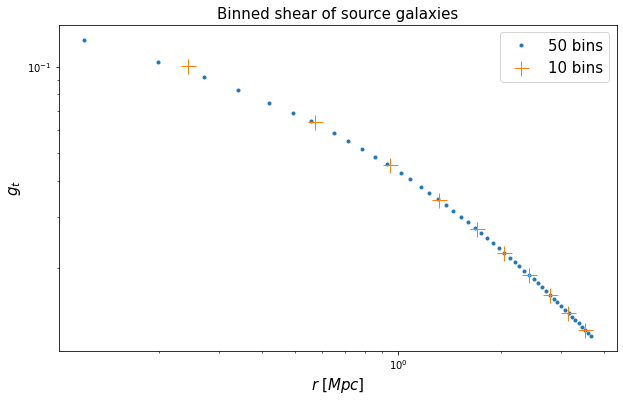

In [20]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(r1, gt_profile1, '.', label='50 bins')
fig.gca().loglog(r2, gt_profile2, '+', markersize=15, label='10 bins')
plt.legend(fontsize=fsize)

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

After running `clmm.polaraveraging.make_shear_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [21]:
for n in cl.profile.colnames: cl.profile[n].format = "%6.3e"
cl.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 2.046e-01 2.114e-01  2.126e-01 1.011e-01 9.646e-05  6.939e-18 9.813e-18 8.000e-01 0.000e+00 2.000e+00
 2.447e-01 2.468e-01  2.527e-01 9.519e-02 8.915e-05 -3.469e-18 2.453e-18 8.000e-01 0.000e+00 2.000e+00
 2.767e-01 2.813e-01  2.848e-01 9.024e-02 1.771e-04 -3.469e-18 5.058e-18 8.000e-01 0.000e+00 4.000e+00
 3.409e-01 3.455e-01  3.489e-01 8.245e-02 1.596e-04  2.891e-19 2.361e-19 8.000e-01 6.410e-17 3.000e+00
 3.809e-01 3.858e-01  3.890e-01 7.826e-02 1.223e-04 -2.429e-17 4.907e-18 8.000e-01 6.410e-17 3.000e+00
 3.890e-01 3.933e-01  3.970e-01 7.752e-02 1.128e-05 -2.168e-19 1.533e-19 8.000e-01 0.000e+00 2.000e+00
 4.050e-01 4.074e-01  4.130e-01 7.618e-02 1.223e-04 -3.469e-18 2.453e-18 8.000e-01 0.000e+00 2.000e+00
 4.290e-01 4.349e-01  4.371e-01 7.370e-02 8.070e-05  4.337e-18 3.900e-18 

## Modeling the data

We next demonstrate a few of the procedures one can perform once a cosmology has been chosen.

In [22]:
class GaussGammaT (Ncm.DataGaussDiag):
    z_cluster = GObject.Property (type = float, flags = GObject.PARAM_READWRITE)
    z_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    r_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    
    def __init__ (self, z_cluster, r_source, z_source, gt_profile, moo = None):
        Ncm.DataGaussDiag.__init__ (self, n_points = len (gt_profile))
        
        self.moo = moo if moo else clmm.Modeling ()
        
        assert len (gt_profile) == len (z_source)
        assert len (gt_profile) == len (r_source)
        
        self.set_size (len (gt_profile))
        
        self.props.z_cluster = z_cluster
        self.props.z_source  = Ncm.Vector.new_array (z_source)
        self.props.r_source  = Ncm.Vector.new_array (r_source)
        
        self.y.set_array (gt_profile)
        
        self.sigma.set_all (1.0e-2)
        
        self.set_init (True)
    
    def do_get_length (self):
        return self.np

    def do_get_dof (self):
        return self.np

    def do_begin (self):
        pass

    def do_prepare (self, mset):
        self.moo.set_mset (mset)
        
    def do_mean_func (self, mset, vp):
        vp.set_array (self.moo.eval_reduced_shear (self.props.r_source.dup_array (), self.props.z_cluster, self.props.z_source.dup_array ()))
        return

GObject.type_register (GaussGammaT)

moo1 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo1.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo1.set_concentration (4.0)

moo2 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo2.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo2.set_concentration (4.0)

ggt1 = GaussGammaT (z_cluster = cluster_z, r_source = r1*cosmo.h, z_source = z1, gt_profile = gt_profile1, moo = moo1)
ggt2 = GaussGammaT (z_cluster = cluster_z, r_source = r2*cosmo.h, z_source = z2, gt_profile = gt_profile2, moo = moo2)

mset1 = ggt1.moo.get_mset ()
mset2 = ggt2.moo.get_mset ()

MDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:MDelta")
cDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

mset1.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset1.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FIXED)
mset1.prepare_fparam_map ()

mset2.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset2.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FIXED)
mset2.prepare_fparam_map ()

dset1 = Ncm.Dataset.new ()
dset1.append_data (ggt1)
lh1 = Ncm.Likelihood.new (dset1)

dset2 = Ncm.Dataset.new ()
dset2.append_data (ggt2)
lh2 = Ncm.Likelihood.new (dset2)

fit1 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh1, mset1, Ncm.FitGradType.NUMDIFF_FORWARD)
fit2 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh2, mset2, Ncm.FitGradType.NUMDIFF_FORWARD)

fit1.run (Ncm.FitRunMsgs.SIMPLE)
fit1.fisher ()
fit1.log_covar ()

fit2.run (Ncm.FitRunMsgs.SIMPLE)
fit2.fisher ()
fit2.log_covar ()



#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0036590
#  iteration            [000046]
#  function evaluations [000048]
#  gradient evaluations [000000]
#  degrees of freedom   [000048]
#  m2lnL     =   0.0119572796139294 (    0.01195728 )
#  Fit parameters:
#     1.434345703125e+15  
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                  ----------------
# MDelta[04000:01] =  1.434e+15   +/-  8.175e+13   |  1           |
#                                                  ----------------
#-------------------------------------------------------------------------------

Next, we calculate the reduced tangential shear predicted by the two models.

In [23]:
rr = np.logspace(-2, np.log10(5), 100)

gt_model1 = moo1.eval_reduced_shear (rr*cosmo.h, cluster_z, src_z)
gt_model2 = moo2.eval_reduced_shear (rr*cosmo.h, cluster_z, src_z)

m_est1 = mset1.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h
m_est2 = mset2.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h

print ("mest1 % 22.15g mest2 % 22.15g" % (m_est1, m_est2))

mest1    1.0040419921875e+15 mest2     1.047498046875e+15


We visualize the two predictions of reduced tangential shear.

Text(0, 0.5, 'reduced tangential shear')

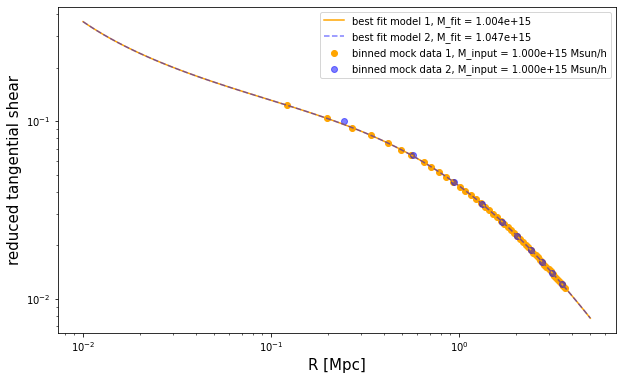

In [24]:
fig = plt.figure(figsize=(10, 6))

fig.gca().scatter(r1, gt_profile1, color='orange',
                  label='binned mock data 1, M_input = %.3e Msun/h' % cluster_m)
fig.gca().plot(rr, gt_model1, color='orange',
               label='best fit model 1, M_fit = %.3e' % m_est1)

fig.gca().scatter(r2, gt_profile2, color='blue', alpha=0.5,
                  label='binned mock data 2, M_input = %.3e Msun/h' % cluster_m)
fig.gca().plot(rr, gt_model1, color='blue', linestyle='--', alpha=0.5,
               label='best fit model 2, M_fit = %.3e' % m_est2)

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)